In [24]:
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import gala.integrate as gi
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
import scipy.optimize as opt

First, define a gravitational potential.

In [25]:
pot = gp.MilkyWayPotential()

Select a star.

In [26]:
dict5 = {
    'ra': 139.4978105603, #degree
    'e_ra': 0.0001, #degree
    'dec': 67.3773227272, #degree
    'e_dec': 0.0001, #degree
    'dist': 44.20, #kpc
    'e_dist': 5.09, #kpc
    'pmra': 0.00, #mas/yr
    'e_pmra': 0.08, #mas/yr
    'pmdec': -0.99, #mas/yr
    'e_pmdec': 0.11, #mas/yr
    'rv': 545.50, #km/s
    'e_rv': 4.30, #km/s
    }

hvs5 = coord.SkyCoord(
    ra=dict5['ra'] * u.degree,
    dec=dict5['dec'] * u.degree,
    distance=dict5['dist'] * u.kpc,
    pm_ra_cosdec=dict5['pmra'] * (u.mas / u.yr),
    pm_dec=dict5['pmdec'] * (u.mas / u.yr),
    radial_velocity=dict5['rv'] * (u.km / u.s),
    frame="icrs"
)

hvs5_GC = hvs5.transform_to(coord.Galactocentric)

Set initial conditions and specify time-stepping

In [27]:
hvs5_ics = gd.PhaseSpacePosition(pos=hvs5_GC.cartesian.xyz, vel=hvs5_GC.velocity.d_xyz)
hvs5_orbit1 = pot.integrate_orbit(hvs5_ics, dt=-0.1*u.Myr, n_steps=10000) # 1 Gyr
hvs5_orbit2 = pot.integrate_orbit(hvs5_ics, dt=-0.1*u.Myr, n_steps=5000) # 500 Myr
hvs5_orbit3 = pot.integrate_orbit(hvs5_ics, dt=-0.1*u.Myr, n_steps=1000) # 100 Myr

Sample 100 clones from the uncertainties.

In [28]:
n_samples = 1000
ra_samples = np.random.normal(dict5['ra'], dict5['e_ra'], n_samples)
dec_samples = np.random.normal(dict5['dec'], dict5['e_dec'], n_samples)
dist_samples = np.random.normal(dict5['dist'], dict5['e_dist'], n_samples)
pmra_samples = np.random.normal(dict5['pmra'], dict5['e_pmra'], n_samples)
pmdec_samples = np.random.normal(dict5['pmdec'], dict5['e_pmdec'], n_samples)
rv_samples = np.random.normal(dict5['rv'], dict5['e_rv'], n_samples)

ics_list = []
for ra, dec, dist, pmra, pmdec, rv in zip(ra_samples, dec_samples, dist_samples, pmra_samples, pmdec_samples, rv_samples):
    sc = coord.SkyCoord(ra=ra * u.degree,
                  dec=dec * u.degree,
                  distance=dist * u.kpc,
                  pm_ra_cosdec=pmra * (u.mas / u.yr),
                  pm_dec=pmdec * (u.mas / u.yr),
                  radial_velocity=rv * (u.km / u.s),
                  frame="icrs")
    gc = sc.transform_to(coord.Galactocentric)
    ics = gd.PhaseSpacePosition(pos=gc.cartesian.xyz, vel=gc.velocity.d_xyz)
    ics_list.append(ics)

Integrate all of the orbits

In [29]:
orbits1 = []
orbits2 = []
orbits3 = []
orbits1.append(hvs5_orbit1)
orbits2.append(hvs5_orbit2)
orbits3.append(hvs5_orbit3)
for ics in ics_list:
    orbit1 = pot.integrate_orbit(ics, dt=-0.1*u.Myr, n_steps=10000)
    orbit2 = pot.integrate_orbit(ics, dt=-0.1*u.Myr, n_steps=5000)
    orbit3 = pot.integrate_orbit(ics, dt=-0.1*u.Myr, n_steps=1000)
    orbits1.append(orbit1)
    orbits2.append(orbit2)
    orbits3.append(orbit3)

Plot the final positions of the star after 1 Gyr

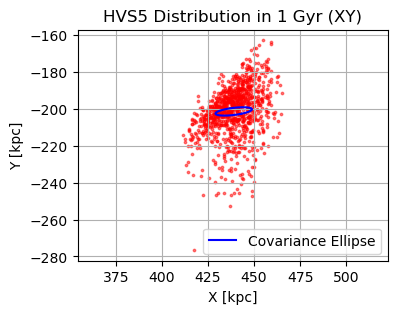

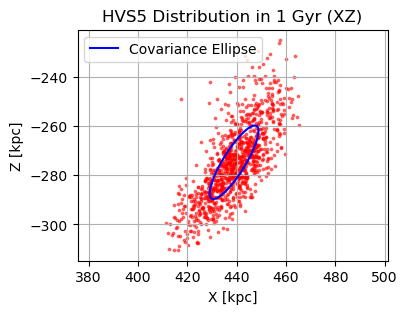

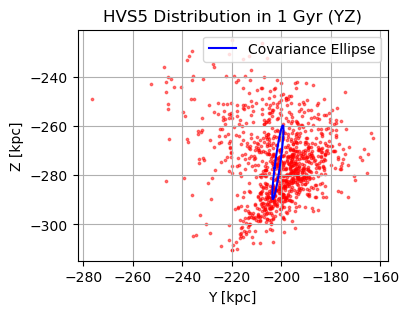

In [30]:
red_points = []

for i, orbit in enumerate(orbits1):
    final_pos = orbit[-1].pos.xyz.to(u.kpc).value[:3]
    if i == 0:
        pass
        # plt.scatter(final_pos[0], final_pos[1], c='black', label='Original')
    else:
        # plt.scatter(final_pos[0], final_pos[1], c='red')
        red_points.append(final_pos)

# Covariance

red_points = np.array(red_points)

cov = np.cov(red_points.T)
mean_pos = np.mean(red_points, axis=0)

eigenvalues, eigenvectors = np.linalg.eig(cov)
axes_lengths = np.sqrt(eigenvalues)
theta = np.linspace(0, 2*np.pi, 200)
circle = np.array([np.cos(theta), np.sin(theta), np.zeros_like(theta)]) 
ellipse_3d = (eigenvectors @ (np.diag(axes_lengths) @ circle)) + mean_pos[:, np.newaxis]

ellipse_xy = ellipse_3d[[0, 1], :]
ellipse_xz = ellipse_3d[[0, 2], :]
ellipse_yz = ellipse_3d[[1, 2], :]


# XY Plot

plt.figure(figsize=(4, 3))
plt.plot(ellipse_xy[0], ellipse_xy[1], 'blue', label='Covariance Ellipse')
plt.scatter(red_points[:, 0], red_points[:, 1], s=3, c='red', alpha=0.5)
plt.xlabel("X [kpc]")
plt.ylabel("Y [kpc]")
plt.title("HVS5 Distribution in 1 Gyr (XY)")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

# XZ Plot

plt.figure(figsize=(4, 3))
plt.plot(ellipse_xz[0], ellipse_xz[1], 'blue', label='Covariance Ellipse')
plt.scatter(red_points[:, 0], red_points[:, 2], s=3, c='red', alpha=0.5)
plt.xlabel("X [kpc]")
plt.ylabel("Z [kpc]")
plt.title("HVS5 Distribution in 1 Gyr (XZ)")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

# YZ Plot

plt.figure(figsize=(4, 3))
plt.plot(ellipse_yz[0], ellipse_yz[1], 'blue', label='Covariance Ellipse')
plt.scatter(red_points[:, 1], red_points[:, 2], s=3, c='red', alpha=0.5)
plt.xlabel("Y [kpc]")
plt.ylabel("Z [kpc]")
plt.title("HVS5 Distribution in 1 Gyr (YZ)")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

Plot the final positions of the star after 500 Myr

[[ 208.64234204 -102.11443802 -132.77790517]
 [ 212.67537306  -94.73154767 -132.54216598]
 [ 208.78163961 -110.59242985 -129.9128202 ]
 ...
 [ 214.69259955  -97.97107878 -130.39273191]
 [ 207.86941145 -101.06239758 -137.2895669 ]
 [ 211.05246988  -96.1503157  -137.65022626]]


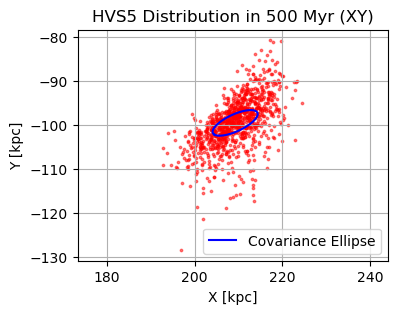

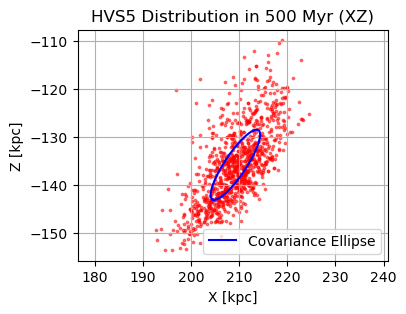

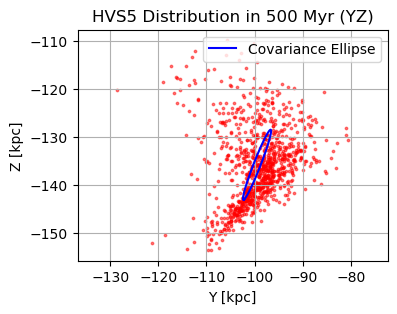

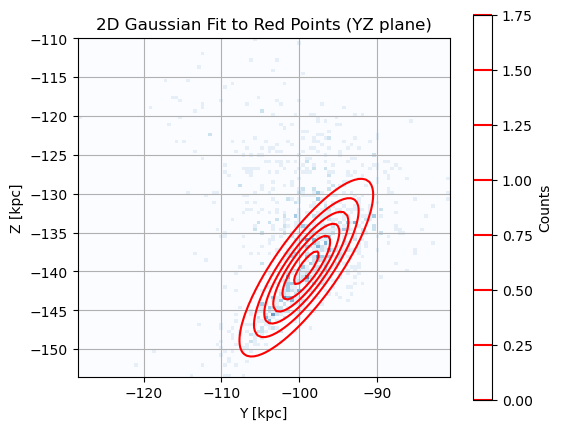

In [31]:
red_points = []

for i, orbit in enumerate(orbits2):
    final_pos = orbit[-1].pos.xyz.to(u.kpc).value[:3]
    if i == 0:
        pass
        # plt.scatter(final_pos[0], final_pos[1], c='black', label='Original')
    else:
        # plt.scatter(final_pos[0], final_pos[1], c='red')
        red_points.append(final_pos)

# Covariance

red_points = np.array(red_points)
print(red_points)

cov = np.cov(red_points.T)
mean_pos = np.mean(red_points, axis=0)

eigenvalues, eigenvectors = np.linalg.eig(cov)
axes_lengths = np.sqrt(eigenvalues)
theta = np.linspace(0, 2*np.pi, 200)
circle = np.array([np.cos(theta), np.sin(theta), np.zeros_like(theta)]) 
ellipse_3d = (eigenvectors @ (np.diag(axes_lengths) @ circle)) + mean_pos[:, np.newaxis]  # shape (3, 200)

ellipse_xy = ellipse_3d[[0, 1], :]
ellipse_xz = ellipse_3d[[0, 2], :]
ellipse_yz = ellipse_3d[[1, 2], :]


# XY Plot

plt.figure(figsize=(4, 3))
plt.plot(ellipse_xy[0], ellipse_xy[1], 'blue', label='Covariance Ellipse')
plt.scatter(red_points[:, 0], red_points[:, 1], s=3, c='red', alpha=0.5)
plt.xlabel("X [kpc]")
plt.ylabel("Y [kpc]")
plt.title("HVS5 Distribution in 500 Myr (XY)")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

# XZ Plot

plt.figure(figsize=(4, 3))
plt.plot(ellipse_xz[0], ellipse_xz[1], 'blue', label='Covariance Ellipse')
plt.scatter(red_points[:, 0], red_points[:, 2], s=3, c='red', alpha=0.5)
plt.xlabel("X [kpc]")
plt.ylabel("Z [kpc]")
plt.title("HVS5 Distribution in 500 Myr (XZ)")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

# YZ Plot

plt.figure(figsize=(4, 3))
plt.plot(ellipse_yz[0], ellipse_yz[1], 'blue', label='Covariance Ellipse')
plt.scatter(red_points[:, 1], red_points[:, 2], s=3, c='red', alpha=0.5)
plt.xlabel("Y [kpc]")
plt.ylabel("Z [kpc]")
plt.title("HVS5 Distribution in 500 Myr (YZ)")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

# Re-try using different technique

x = red_points[:, 0]
y = red_points[:, 1]
z = red_points[:, 2]

bins = 100
hist, yedges, zedges = np.histogram2d(y, z, bins=bins)

y_centers = (yedges[:-1] + yedges[1:]) / 2
z_centers = (zedges[:-1] + zedges[1:]) / 2
y_grid, z_grid = np.meshgrid(y_centers, z_centers)

xdata = np.vstack((y_grid.ravel(), z_grid.ravel()))
zdata = hist.T.ravel()

def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

initial_guess = (np.max(hist), np.mean(y), np.mean(z), 1, 1, 0, 0)
popt, pcov = opt.curve_fit(twoD_Gaussian, xdata, zdata, p0=initial_guess)
fitted_data = twoD_Gaussian(xdata, *popt).reshape(bins, bins)

plt.figure(figsize=(6, 5))
plt.imshow(hist.T, extent=(y.min(), y.max(), z.min(), z.max()), origin='lower', cmap='Blues', alpha=0.6)
plt.contour(y_grid, z_grid, fitted_data, levels=6, colors='red')
plt.xlabel("Y [kpc]")
plt.ylabel("Z [kpc]")
plt.title("2D Gaussian Fit to Red Points (YZ plane)")
plt.colorbar(label="Counts")
plt.grid(True)
plt.show()

Plot the final positions of the star after 100 Myr

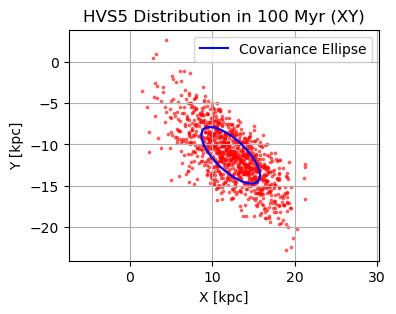

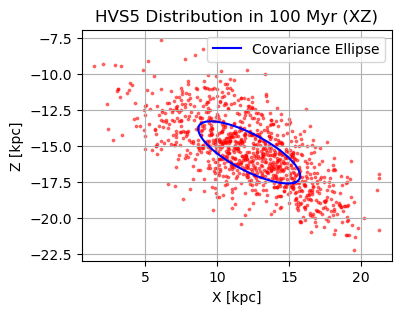

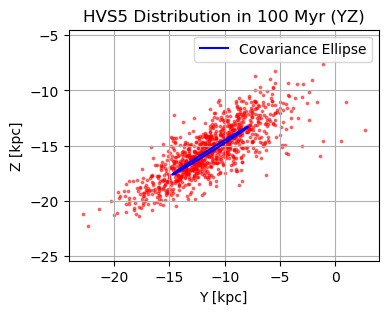

In [32]:
red_points = []

for i, orbit in enumerate(orbits3):
    final_pos = orbit[-1].pos.xyz.to(u.kpc).value[:3]
    if i == 0:
        pass
        # plt.scatter(final_pos[0], final_pos[1], c='black', label='Original')
    else:
        # plt.scatter(final_pos[0], final_pos[1], c='red')
        red_points.append(final_pos)

# Covariance

red_points = np.array(red_points)

cov = np.cov(red_points.T)
mean_pos = np.mean(red_points, axis=0)

eigenvalues, eigenvectors = np.linalg.eig(cov)
axes_lengths = np.sqrt(eigenvalues)
theta = np.linspace(0, 2*np.pi, 200)
circle = np.array([np.cos(theta), np.sin(theta), np.zeros_like(theta)]) 
ellipse_3d = (eigenvectors @ (np.diag(axes_lengths) @ circle)) + mean_pos[:, np.newaxis]  # shape (3, 200)

ellipse_xy = ellipse_3d[[0, 1], :]
ellipse_xz = ellipse_3d[[0, 2], :]
ellipse_yz = ellipse_3d[[1, 2], :]


# XY Plot

plt.figure(figsize=(4, 3))
plt.plot(ellipse_xy[0], ellipse_xy[1], 'blue', label='Covariance Ellipse')
plt.scatter(red_points[:, 0], red_points[:, 1], s=3, c='red', alpha=0.5)
plt.xlabel("X [kpc]")
plt.ylabel("Y [kpc]")
plt.title("HVS5 Distribution in 100 Myr (XY)")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

# XZ Plot

plt.figure(figsize=(4, 3))
plt.plot(ellipse_xz[0], ellipse_xz[1], 'blue', label='Covariance Ellipse')
plt.scatter(red_points[:, 0], red_points[:, 2], s=3, c='red', alpha=0.5)
plt.xlabel("X [kpc]")
plt.ylabel("Z [kpc]")
plt.title("HVS5 Distribution in 100 Myr (XZ)")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

# YZ Plot

plt.figure(figsize=(4, 3))
plt.plot(ellipse_yz[0], ellipse_yz[1], 'blue', label='Covariance Ellipse')
plt.scatter(red_points[:, 1], red_points[:, 2], s=3, c='red', alpha=0.5)
plt.xlabel("Y [kpc]")
plt.ylabel("Z [kpc]")
plt.title("HVS5 Distribution in 100 Myr (YZ)")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()